# Градиентный бустинг

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Создадим датасет в виде зашумленного косинуса

In [122]:
X = np.random.rand(100) * 10 - 5 

In [123]:
y = np.cos(X) +np.random.rand(100)/2 - 0.25
y[:5]

array([-0.37010752, -0.80776086, -0.90945653, -0.85508137,  0.1013511 ])

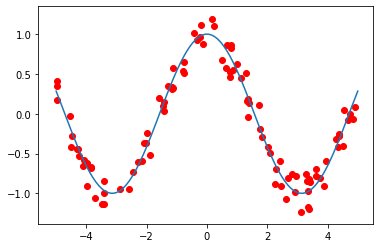

In [124]:
plt.plot(np.linspace(-5, 5, 100), np.cos(np.linspace(-5, 5, 100)))
plt.scatter(X, y, c='r')

## Классический GBM алгоритм

- набор данных $\large \left\{ (x_i, y_i) \right\}_{i=1, \ldots,n}$;
- число итераций $\large M$;
- выбор функции потерь $\large L(y, f)$ с выписанным градиентом;
- выбор семейства функций базовых алгоритмов $\large h(x, \theta)$, с процедурой их обучения;
- дополнительные гиперпараметры $\large h(x, \theta)$, например, глубина дерева у деревьев решений;

Единственный момент, который остался без внимания — начальное приближение $\large f_0(x)$. Для простоты, в качестве инициализации используют просто константное значение $\large \gamma$. Его, а также оптимальный коэффициент $\large \rho $ находят бинарным поиском, или другим line search алгоритмом относительно исходной функции потерь (а не градиента). Итак, GBM алгоритм:


1. Инициализировать GBM константным значением $\large \hat{f}(x) = \hat{f}_0, \hat{f}_0 = \gamma, \gamma \in \mathbb{R}$
$\large \hat{f}_0 = \underset{\gamma}{\arg\min} \ \sum_{i = 1}^{n} L(y_i, \gamma)$
2. Для каждой итерации $\large t = 1, \dots, M$ повторять:
   
    2.1 Посчитать псевдо-остатки $\large r_t$
    $\large r_{it} = -\left[\frac{\partial L(y_i, f(x_i))}{\partial f(x_i)}\right]_{f(x)=\hat{f}(x)}, \quad for i=1,\ldots,n$

    2.2 Построить новый базовый алгоритм $\large h_t(x)$ как регрессию на псевдо-остатках $\large \left\{ (x_i, r_{it}) \right\}_{i=1, \ldots,n}$
    
    2.3 Найти оптимальный коэффициент $\large \rho_t $ при $\large h_t(x)$ относительно исходной функции потерь
$\large \rho_t = \underset{\rho}{\arg\min} \ \sum_{i = 1}^{n} L(y_i, \hat{f}(x_i) + \rho \cdot h(x_i, \theta))$
    
    2.4 Сохранить $\large \hat{f_t}(x) = \rho_t \cdot h_t(x)$
    
    2.5 Обновить текущее приближение $\large \hat{f}(x)$
$\large \hat{f}(x) \leftarrow \hat{f}(x) + \hat{f_t}(x) = \sum_{i = 0}^{t} \hat{f_i}(x)$

1. Скомпоновать итоговую GBM модель $\large \hat{f}(x)$
$\large \hat{f}(x) = \sum_{i = 0}^M \hat{f_i}(x) $

## Пошаговый пример работы GBM

Игрушечные данные $\large \left\{ (x_i, y_i) \right\}_{i=1, \ldots,100}$ ✓

Число итераций $\large M = 3$ ✓;

Среднеквадратичная функция потерь $\large L(y, f) = (y-f)^2$ ✓

Градиент $\large L(y, f) = L_2$ loss это просто остатки $\large r = (y - f)$ ✓;

Деревья решений в качестве базовых алгоритмов $\large h(x)$ ✓;

Гиперпараметры деревьев решений: глубина деревьев равна 2 ✓;

У среднеквадратичной ошибки все просто и с инициализацией $\large \gamma$ и с коэффициентами $\large \rho_t$. А именно, инициализировать GBM мы будем средним значением $\large \gamma = \frac{1}{n} \cdot \sum_{i = 1}^n y_i$, а все $\large \rho_t$ равны 1.


In [125]:
from sklearn.tree import DecisionTreeRegressor

estimator = DecisionTreeRegressor(max_depth=2)
n_estimators = 100

In [126]:
gamma = np.sum(y) / len(y)
def f(x):
    return np.ones(len(y)) * gamma

estimators = [f]
rho = [1]
r = []

In [127]:
def gbm_predict(estimators, rho, x):
    y = estimators[0](x)
    for i in range(1, len(estimators)):
        y += rho[i] * estimators[i].predict(x)
    return y

In [129]:
for i in range(1, n_estimators):
    if i == 1:
        y_pred = estimators[0](X)
    else:
        y_pred = gbm_predict(estimators, rho, X.reshape(-1, 1))
    r_it = -2/len(y) * (y_pred - y)
    f_t = DecisionTreeRegressor(max_depth=2)
    f_t.fit(X.reshape(-1, 1), r_it)
    rho_t = 1
    estimators.append(f_t)
    rho.append(rho_t)
    r.append(r_it)

In [130]:
rho[0], estimators[1], len(rho), len(estimators)

(1,
 DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort=False, random_state=None, splitter='best'),
 101,
 101)

In [131]:
data = np.linspace(-5, 5, 100)
y_pred = gbm_predict(estimators, rho, data.reshape(-1, 1))

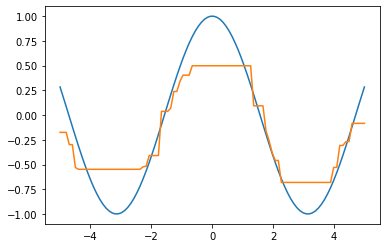

In [132]:
plt.plot(data, np.cos(data))
plt.plot(data, y_pred)